IMPORTING LIBRARIES 

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns


CONFIG

In [5]:
img_size = 224
batch_size = 32
epochs = 25
base_dir = "classified_dataset"

DATA AUGMENTATION

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1665 images belonging to 4 classes.
Found 206 images belonging to 4 classes.
Found 211 images belonging to 4 classes.


BUILDING MODEL

In [7]:
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

CALLBACKS

In [8]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)


TRAIN

In [9]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

C:\Users\omara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 554ms/step - accuracy: 0.4911 - loss: 1.2751 - val_accuracy: 0.8447 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 526ms/step - accuracy: 0.7644 - loss: 0.6479 - val_accuracy: 0.9029 - val_loss: 0.3330 - learning_rate: 0.0010
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 520ms/step - accuracy: 0.8329 - loss: 0.4852 - val_accuracy: 0.8447 - val_loss: 0.3546 - learning_rate: 0.0010
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 539ms/step - accuracy: 0.8395 - loss: 0.4423 - val_accuracy: 0.9369 - val_loss: 0.2489 - learning_rate: 0.0010
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 567ms/step - accuracy: 0.8510 - loss: 0.4086 - val_accuracy: 0.9175 - val_loss: 0.2155 - learning_rate: 0.0010
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 576ms/step - accuracy: 0.8715 - loss: 0.3507 - val_accuracy: 0.9320 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - accuracy: 0.8926 - loss: 0.

EVALUATION ON TEST 

In [10]:
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.2%}, Test Loss: {test_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.9612 - loss: 0.1093
Test Accuracy: 95.26%, Test Loss: 0.1569


PLOTTING

BASIC TRAINING METRICS

In [11]:
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(14, 5))


<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

PREDICTIONS & LABELS

In [12]:
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 430ms/step


ACCURACY AND LOSS CURVES

In [13]:
plt.figure(figsize=(14, 5))


<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

ACCURACY PLOT

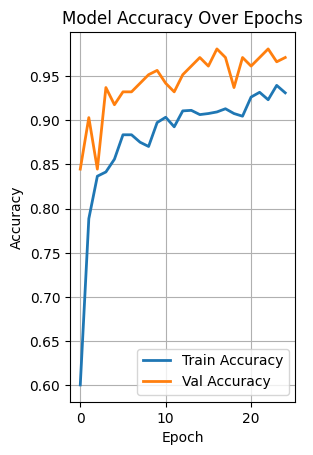

In [14]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig("plots/accuracy_curve.png")

LOSS

In [15]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("plots/loss_curve.png")
plt.close()

CONFUSION MATRIX

In [16]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("plots/confusion_matrix.png")
plt.close()

PER CLASS ACCURACY

In [17]:
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=class_accuracy)
plt.ylim(0, 1)
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Class")
plt.grid(True)
plt.savefig("plots/per_class_accuracy.png")
plt.close()

SAVE CLASSIFICATION REPORT 

In [18]:
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

with open("plots/classification_report.txt", "w") as f:
    f.write(report)

print("✅ All plots and the classification report are saved in the 'plots/' folder.")

Classification Report:
               precision    recall  f1-score   support

       qiyam       0.98      0.98      0.98        61
        ruku       0.95      0.93      0.94        57
     sitting       0.98      0.91      0.95        47
       sujud       0.90      0.98      0.94        46

    accuracy                           0.95       211
   macro avg       0.95      0.95      0.95       211
weighted avg       0.95      0.95      0.95       211

✅ All plots and the classification report are saved in the 'plots/' folder.


SAVING THE MODEL 

In [19]:
model.save("prayer_posture_model.h5")


CONVERTING .H5 TO .TFLITE FOR APP DEVELOPMENT 

In [20]:

model = tf.keras.models.load_model("prayer_posture_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("prayer_posture_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\omara\AppData\Local\Temp\tmpkck887q0\assets


INFO:tensorflow:Assets written to: C:\Users\omara\AppData\Local\Temp\tmpkck887q0\assets


Saved artifact at 'C:\Users\omara\AppData\Local\Temp\tmpkck887q0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  1701789769488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789770640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789771024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789770832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789768528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789772176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789772560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789772944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789772752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1701789770064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  170178